# 자연지리학개론 기말 프로젝트 실험 1

## 1. 사전 작업

### 1.1. Importing Modules

분석에 필요한 모듈인 `numpy`, `matplotlib` 등을 불러온다.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import rasterio
from affine import Affine
from pyproj import Transformer
import contextily as ctx

### 1.2. Preparing Data

#### 1.2.1. Loading Data

연속수치지형도 고도 데이터를 합쳐 interpolation으로 제작한 DEM을 불러온다.

연속수치지형도는 안양008, 안양009, 안양018, 안양019, 안양028, 안양029 연속수치지형도 중 등고선을 병합한 후 interpolation algorithm을 통해 DEM을 제작했다.

In [2]:
with rasterio.open('data/combined_dem.tif') as src:
    dem_array = src.read(1, masked=True)
    dem_transform = src.transform
    dem_crs = 'EPSG:5179'
    width = src.width
    height = src.height

#### 1.2.2. Tidying Data

In [3]:
mask = ~dem_array.mask
valid_rows = np.any(mask, axis=1)
valid_cols = np.any(mask, axis=0)

row_start, row_end = np.where(valid_rows)[0][[0, -1]]
col_start, col_end = np.where(valid_cols)[0][[0, -1]]

row_end += 1
col_end += 1

dem_array_cropped = dem_array[row_start:row_end, col_start:col_end]
cropped_transform = dem_transform * Affine.translation(col_start, row_start)

cropped_height, cropped_width = dem_array_cropped.shape

## 2. 실험 진행

실험 진행 순서는 다음과 같다.

1. 각 픽셀에 점 하나를 위치한다. 이때 DEM의 resolution은 5m/px이므로, 각 점은 5m 간격으로 위치해 있는 것으로 이해하면 된다.

2. DEM을 통해 계산한 각 점 위치의 경사를 따라 점을 이동시킨다. 이때 새로 계산된 점의 위치는

$$
\phi_{n+1} = \phi_{n} - \eta \nabla \phi_{n}
$$

이다. 이때 $n$은 하강 시행 횟수, $\phi_{n}$은 $n$번째 시행 횟수에서의 점의 위치, $\eta$는 하강 강도 (여기서는 1m), $\nabla \phi_{n}$은 점에서의 위치에서의 경사 방향을 의미한다.

### 2.1. 각 점에 대한 gradient 계산

DEM의 각 지점에 대해 gradient를 계산해준다.

In [4]:
dem_array_filled = dem_array_cropped.filled(np.nan)

pixel_width = cropped_transform.a
pixel_height = -cropped_transform.e

dz_dy, dz_dx = np.gradient(dem_array_filled, pixel_height, pixel_width)

### 2.2. 각 점의 초기값 부여 (각 픽셀에 점 설정)

실험에서 사용될 점들의 초기값으로 픽셀 하나에 점 하나를 둔다.

In [5]:
dots = []
for i in range(cropped_height):
    for j in range(cropped_width):
        if not dem_array_cropped.mask[i, j]:
            x, y = cropped_transform * (j + 0.5, i + 0.5)
            dots.append([x, y])

dots_xy = np.array(dots)

print(f"Initialized {dots_xy.shape[0]} dots.")

Initialized 1486061 dots.


### 2.3. 점 이동 함수 정의

각 점을 이동시키는 함수 `move_dots`를 정의한다.

In [6]:
def move_dots(dots_xy, dz_dx, dz_dy, transform, step_size=1, tolerance=1e-4):
    # Map x,y to row,col
    inv_transform = ~transform
    cols, rows = inv_transform * (dots_xy[:, 0], dots_xy[:, 1])
    
    # Integer pixel coordinates
    rows_int = np.clip(np.round(rows).astype(int), 0, dz_dx.shape[0]-1)
    cols_int = np.clip(np.round(cols).astype(int), 0, dz_dx.shape[1]-1)

    # Get local gradient at each dot
    grad_x = dz_dx[rows_int, cols_int]
    grad_y = dz_dy[rows_int, cols_int]

    # Compute movement vector (steepest descent: negative gradient)
    move_x = -grad_x
    move_y = -grad_y

    norm = np.sqrt(move_x**2 + move_y**2)
    norm[norm == 0] = 1e-6  # avoid division by zero

    # Normalize and scale
    move_x = (move_x / norm) * step_size
    move_y = (move_y / norm) * step_size

    # If slope is too small (i.e., norm < tolerance), don't move
    move_x[norm < tolerance] = 0
    move_y[norm < tolerance] = 0

    # Update positions
    dots_xy[:, 0] += move_x
    dots_xy[:, 1] += move_y

    return dots_xy

### 2.4. Hyperparameter 설정

실험의 특성을 결정짓는 변수를 지정해준다. 해당 변수는:

1. `n_steps`: 점들을 이동시킬 횟수. 여기서는 2000

2. `step_size`: 위의 식에서의 $\eta$. 경사를 따라 이동시키는 거리의 강도. 여기서는 1(m)

3. `tolerance`: 어느 값 이하의 경사는 0으로 간주하여 점을 더 이상 이동시키지 않을 것이다. 여기서는 $10^{-8}$

In [7]:
n_steps = 2000
step_size = 1  # movement per step
tolerance = 1e-8

### 2.5. 점 이동

`snapshots`를 통하여 매번 점들을 이동시킨 결과를 저장할 것이다.

In [8]:
snapshots = []
snapshots.append(dots_xy.copy())  # Save initial state

for step in range(1, n_steps + 1):
    dots_xy = move_dots(dots_xy, dz_dx, dz_dy, cropped_transform, step_size=step_size, tolerance=tolerance)

    if step % (n_steps // 40) == 0:
        print(f"Saving snapshot at step {step}")
    snapshots.append(dots_xy.copy())

print(f"Finished {n_steps} steps and saved {len(snapshots)} snapshots.")


/var/folders/lt/fs10s0z54t50qc_bnmy8hbnr0000gn/T/ipykernel_8597/368801256.py:7: RuntimeWarning: invalid value encountered in cast
  rows_int = np.clip(np.round(rows).astype(int), 0, dz_dx.shape[0]-1)
/var/folders/lt/fs10s0z54t50qc_bnmy8hbnr0000gn/T/ipykernel_8597/368801256.py:8: RuntimeWarning: invalid value encountered in cast
  cols_int = np.clip(np.round(cols).astype(int), 0, dz_dx.shape[1]-1)


Saving snapshot at step 50
Saving snapshot at step 100
Saving snapshot at step 150
Saving snapshot at step 200
Saving snapshot at step 250
Saving snapshot at step 300
Saving snapshot at step 350
Saving snapshot at step 400
Saving snapshot at step 450
Saving snapshot at step 500
Saving snapshot at step 550
Saving snapshot at step 600
Saving snapshot at step 650
Saving snapshot at step 700
Saving snapshot at step 750
Saving snapshot at step 800
Saving snapshot at step 850
Saving snapshot at step 900
Saving snapshot at step 950
Saving snapshot at step 1000
Saving snapshot at step 1050
Saving snapshot at step 1100
Saving snapshot at step 1150
Saving snapshot at step 1200
Saving snapshot at step 1250
Saving snapshot at step 1300
Saving snapshot at step 1350
Saving snapshot at step 1400
Saving snapshot at step 1450
Saving snapshot at step 1500
Saving snapshot at step 1550
Saving snapshot at step 1600
Saving snapshot at step 1650
Saving snapshot at step 1700
Saving snapshot at step 1750
Savin

## 3. 실험 결과 시각화

### 3.1. 단일 프레임에 대한 결과 시각화

#### 3.1.1. 일반 시각화

step의 index가 주어져 있을 때 그 결과를 시각화한다.

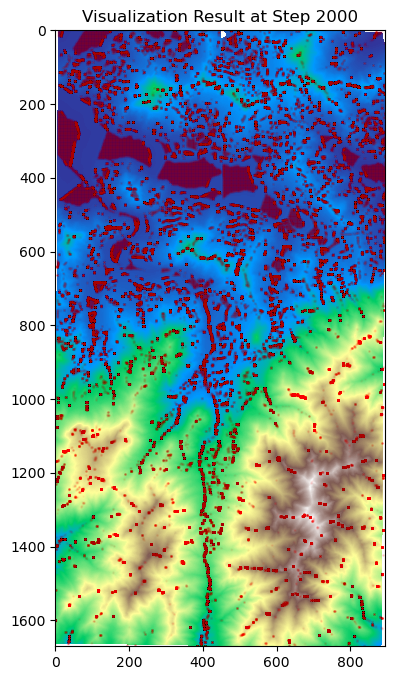

In [9]:
# Choose snapshot index
snapshot_idx = 2000  # 0 = initial, 1 = after 10 steps, etc.

# Extract dots
dots = snapshots[snapshot_idx]

# Plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(dem_array_cropped, cmap='terrain', origin='upper')
ax.scatter(
    (dots[:, 0] - cropped_transform.c) / pixel_width,  # X pixel
    (dots[:, 1] - cropped_transform.f) / -pixel_height,  # Y pixel
    color='red', s=1, alpha = 0.01
)
ax.set_title(f"Visualization Result at Step {snapshot_idx}")
ax.set_xlim(0, dem_array.shape[1])
ax.set_ylim(dem_array.shape[0], 0)
plt.show()

#### 3.1.2. OpenStreetMap 배경을 반영한 시각화

3.1.1.에서 만든, relief map을 바탕으로 한 결과에서는 어떠한 시설이 점 위에 있는지 알 수 없으므로, 배경을 OpenStreetMap으로 바꿔준다.

먼저 하나의 step을 불러온다.

In [10]:
# Load one snapshot
snapshot_index = 250
snapshot = snapshots[snapshot_index]

이후 OSM 배경을 가지고 시각화해준다.

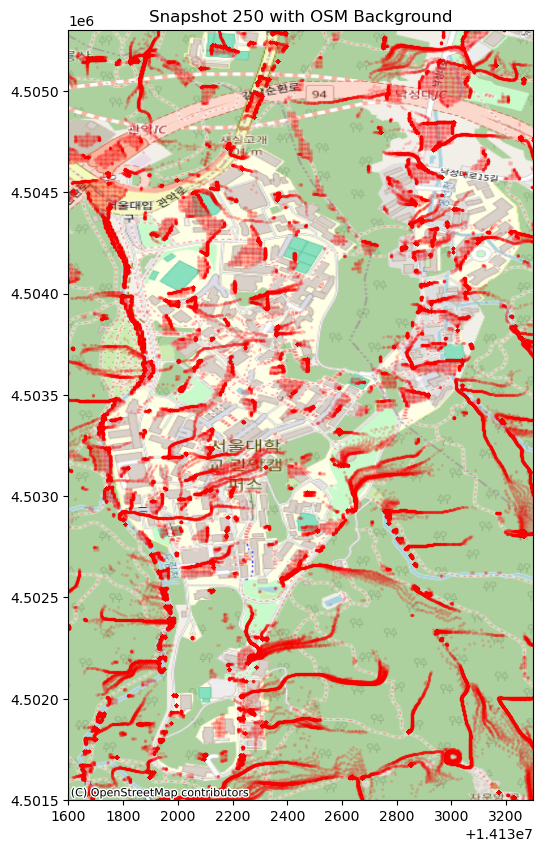

In [11]:
# === 1. Setup: Load DEM and Snapshot ===
# Already Done

# === 2. Reproject to EPSG:3857 (Web Mercator) ===

# Initialize transformer for EPSG:5179 to EPSG:3857
transformer = Transformer.from_crs("EPSG:5179", "EPSG:3857", always_xy=True)

# Reproject the snapshot to EPSG:3857 (Web Mercator)
lon, lat = transformer.transform(snapshot[:, 0], snapshot[:, 1])
snapshot_3857 = np.vstack((lon, lat)).T

# === 3. Set up Plotting: Define plot extent and colors ===

# Get min/max coordinates of the snapshot to set plot boundaries
min_x, max_x = snapshot_3857[:, 0].min(), snapshot_3857[:, 0].max()
min_y, max_y = snapshot_3857[:, 1].min(), snapshot_3857[:, 1].max()

# === 4. Create the Plot with OpenStreetMap Background ===

# Create the plot
fig, ax = plt.subplots(figsize=(6, 10))

# Set xlim and ylim based on your data's bounds
ax.set_xlim(1600 + 1.413e7, 3300 + 1.413e7) # 서울대 캠퍼스 주변만 시각화
ax.set_ylim(4.5015 * 1e6, 4.5053 * 1e6)

# Add OpenStreetMap tiles (Web Mercator)
ctx.add_basemap(ax, crs="EPSG:3857", source=ctx.providers.OpenStreetMap.Mapnik)

# === 5. Plot the Dots ===

# Plot the snapshot dots
ax.scatter(snapshot_3857[:, 0], snapshot_3857[:, 1], color='red', s=2, alpha = 0.1)

# Set title
ax.set_title(f"Snapshot {snapshot_index} with OSM Background")

# Show the plot
plt.show()


### 3.2. 여러 프레임을 대상으로 한 변화 동영상 제작

구한 모든 이동을 시각화한 결과를 이어붙인 동영상을 만든다.

#### 3.2.1. 관악구 전체 시각화

MovieWriter Pillow unavailable; using Pillow instead.


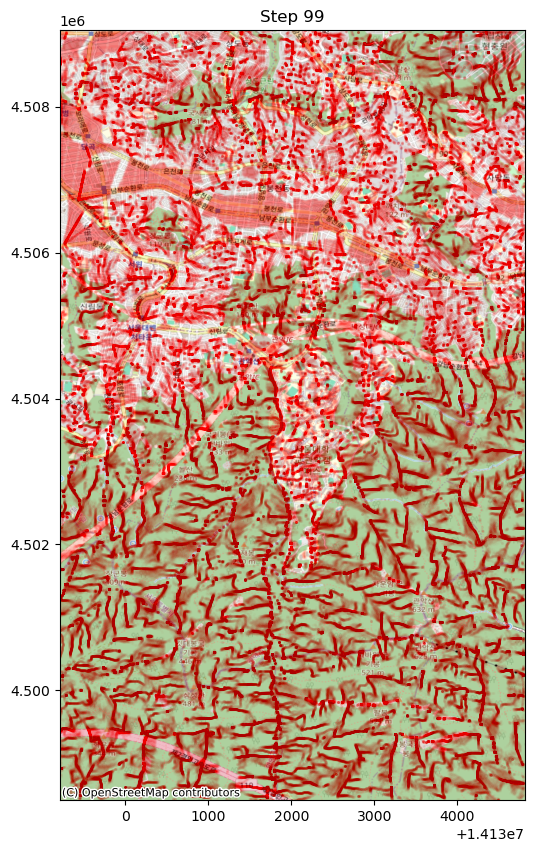

In [12]:
# === 1. Setup projection transformer
transformer = Transformer.from_crs("EPSG:5179", "EPSG:3857", always_xy=True)

# === 2. Project all snapshots to EPSG:3857 (Web Mercator)
snapshots_3857 = []
cutoff = 100
for dots in snapshots[:cutoff]:
    lon, lat = transformer.transform(dots[:, 0], dots[:, 1])
    dots_3857 = np.vstack((lon, lat)).T
    snapshots_3857.append(dots_3857)

# === 3. Set plot extent (bounds)
# Get overall min/max from first snapshot
dots_initial = snapshots_3857[0]
min_x, max_x = dots_initial[:,0].min(), dots_initial[:,0].max()
min_y, max_y = dots_initial[:,1].min(), dots_initial[:,1].max()

# === 4. Create the plot
fig, ax = plt.subplots(figsize=(6, 10))

# Set xlim/ylim
ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)

# Plot empty scatter for moving dots
scat = ax.scatter([], [], color='red', s=2, alpha = 0.01)

# Add OSM basemap
ctx.add_basemap(ax, crs="EPSG:3857", source=ctx.providers.OpenStreetMap.Mapnik)

# === 5. Update function for animation
def update(frame):
    dots = snapshots_3857[frame]
    scat.set_offsets(dots)
    ax.set_title(f"Step {frame}")
    return scat,

# === 6. Animate!
ani = FuncAnimation(fig, update, frames=len(snapshots_3857), interval=50, blit=True)

# === 7. Save to MP4
ani.save('dot_descent_osm.png', writer='Pillow')


저장되는 파일 형식은 `.png`이지만 추후에 `ffmpeg` 모듈을 통해 이를 `.mp4`로 변환해줄 것이다.

#### 3.2.2. 서울대 캠퍼스 주변 시각화

MovieWriter Pillow unavailable; using Pillow instead.


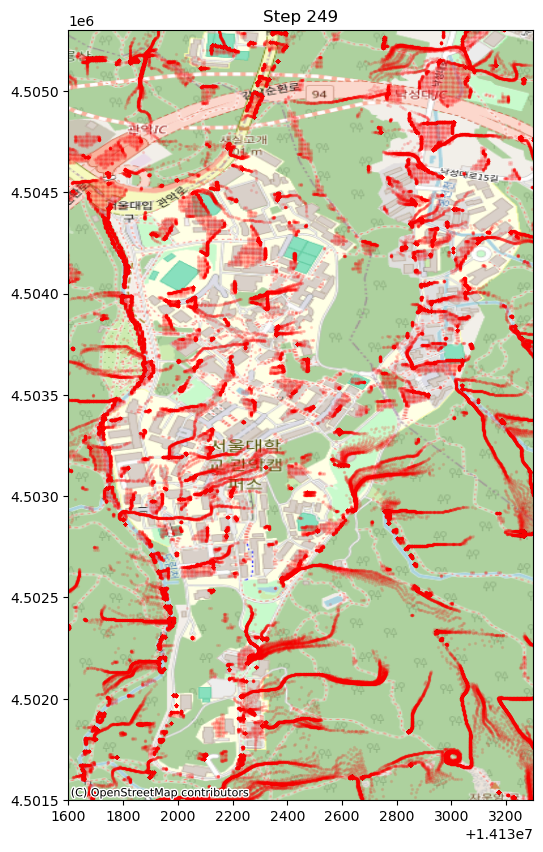

In [13]:
# === 1. Setup projection transformer
transformer = Transformer.from_crs("EPSG:5179", "EPSG:3857", always_xy=True)

# === 2. Project all snapshots to EPSG:3857 (Web Mercator)
snapshots_3857 = []
cutoff = 250
for dots in snapshots[:cutoff]:
    lon, lat = transformer.transform(dots[:, 0], dots[:, 1])
    dots_3857 = np.vstack((lon, lat)).T
    snapshots_3857.append(dots_3857)

# === 3. Set plot extent (bounds)
# Get overall min/max from first snapshot
dots_initial = snapshots_3857[0]

# === 4. Create the plot
fig, ax = plt.subplots(figsize=(6, 10))

# Set xlim/ylim
ax.set_xlim(1600 + 1.413e7, 3300 + 1.413e7)
ax.set_ylim(4.5015 * 1e6, 4.5053 * 1e6)

# Plot empty scatter for moving dots
scat = ax.scatter([], [], color='red', s=2, alpha = 0.1)

# Add OSM basemap
ctx.add_basemap(ax, crs="EPSG:3857", source=ctx.providers.OpenStreetMap.Mapnik)

# === 5. Update function for animation
def update(frame):
    dots = snapshots_3857[frame]
    scat.set_offsets(dots)
    ax.set_title(f"Step {frame}")
    return scat,

# === 6. Animate!
ani = FuncAnimation(fig, update, frames=len(snapshots_3857), interval=50, blit=True)

# === 7. Save to MP4
ani.save('dot_descent_osm_snu.png', writer='Pillow')


## 4. 분석 결과 논의

분석 결과, 다음과 같은 사실을 알 수 있었다.

1. 관악산의 고도 경사를 따라 점들 (즉, 빗물 runoff)이 하강하는데, 이것이 특정 지점에 집중되어 분포한다.

2. 서울대입구 - 봉천역 구간과 같이 관악구 내 경사가 0이어서 빗물이 특정한 방향으로 흐르지 않는 구역들이 다수 관측되었다.

3. 빗물이 하강 경로에 놓여있는 서울대학교 캠퍼스 내 여러 장소가 식별된다.

    - 관악산계곡을 따르는 전체 경로
    
    - 신공학관 (301, 302동) 주변

    - 버들골 주변

    - 기숙사 신관 주변

이에 따라 관악캠퍼스의 특정 지점 (시설)에 대하여 집중적인 배수 대책이 필요함을 알 수 있다.